# Import libraries

In [44]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [45]:
# from google.colab import drive
# drive.mount('/content/drive')

# Read and clean data

In [46]:
df=pd.read_csv('Emotion_final.csv') #Text data
EMBEDDING_FILE= f'glove.6B.100d.txt' #GloVe file path
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [47]:
print(df.shape)

(21459, 2)


In [48]:
df.Emotion.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [49]:
#check if the data is balanced or not
df.Emotion.value_counts() / df.shape[0] *100

happy       32.755487
sadness     29.195209
anger       13.947528
fear        12.358451
love         7.647141
surprise     4.096183
Name: Emotion, dtype: float64

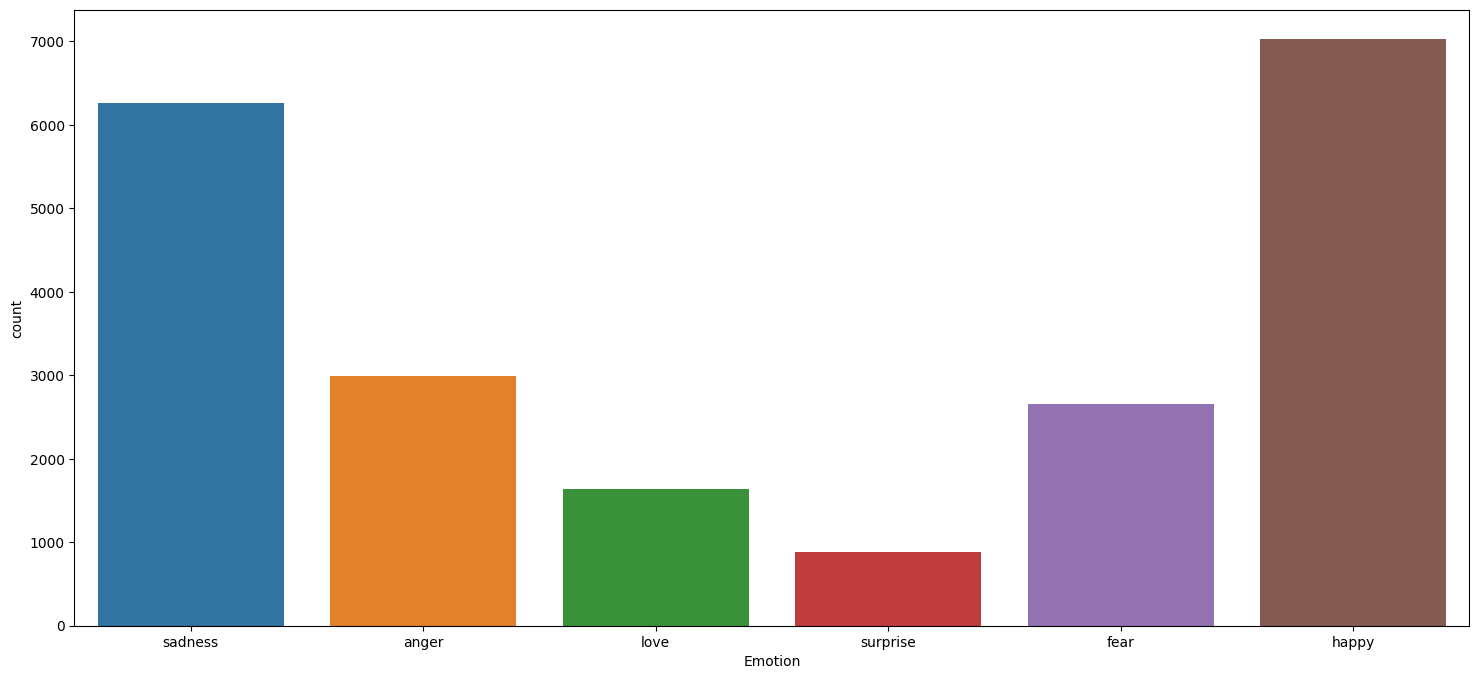

In [50]:
#Target Classes
plt.figure(figsize=(18,8))
sns.countplot(x='Emotion', data=df); 

In [51]:
#print the number of duplicated values 
df.duplicated().sum()

3

In [52]:
#removing duplicated values
index = df[df.duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [53]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
duplicated_rows = df[df['Text'].duplicated(keep=False)].sort_values('Text')
duplicated_rows

,Text,Emotion
11898,i am feeling stressed and more than a bit anxious,sadness
16501,i am feeling stressed and more than a bit anxious,anger
8246,i am not amazing or great at photography but i...,love
3508,i am not amazing or great at photography but i...,happy
15704,i began to feel accepted by gaia on her own terms,happy
...,...,...
11354,i write these words i feel sweet baby kicks fr...,love
7685,im still not sure why reilly feels the need to...,surprise
2908,im still not sure why reilly feels the need to...,fear
9069,ive also made it with both sugar measurements ...,love


In [54]:
#removing duplicated text 
index = df[df['Text'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [55]:
df=df.dropna() #Drop columns with NA values
X=df.drop('Emotion',axis=1) #Taking Text
y=df['Emotion'] #Taking Emotion

In [56]:
X.shape, y.shape

((21405, 1), (21405,))

In [57]:
messages=X.copy()
messages.reset_index(inplace=True) #Drop NA may cause inconsistency in index

In [58]:
import pickle
stopwords_path = 'stopwords.pkl'
with open(stopwords_path, 'rb') as file:
    stopwords_list = pickle.load(file)
    
ps = PorterStemmer()  # reduce word to root form
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords_list] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

In [59]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

# Embedding layer using GloVe 

In [60]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))
# print(embeddings_index)
#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

/home/devraj4522/anaconda3/envs/carefi/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


0.004451992 0.4081574


In [61]:
voc_size=10000 # Vocabulary size
embed_size=100 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [62]:
#Contains the pretrained GloVe weights for the words
len(embedding_matrix)

10000

# Process Input-Output data

In [63]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4297 7208 5578]
 [   0    0    0 ... 5041 6599 1824]
 [   0    0    0 ... 7208  724 8442]
 ...
 [   0    0    0 ... 1700 1792 9924]
 [   0    0    0 ... 4390 9924 4091]
 [   0    0    0 ...    0 9924 6751]]


In [64]:
#Encoding the target outputs to integers

label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
y_final

array([4, 4, 0, ..., 1, 1, 1])

In [65]:
X_final.shape,y_final.shape

((21405, 35), (21405,))

In [66]:
# X_final.shape,y_final.shape

In [67]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=21) 

# Create and train model

In [68]:
# Creating model
model=Sequential()
model.add(Embedding(voc_size, embed_size, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))) #L1 regularization
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

2023-05-21 16:30:41.348617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 16:30:41.350997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 16:30:41.352492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 dropout_3 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [69]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=40,batch_size=64,callbacks = [model_save])

Epoch 1/40


2023-05-21 16:32:31.106806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 16:32:31.108817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 16:32:31.110199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

241/241 [==============================] - ETA: 0s - loss: 3.5902 - accuracy: 0.3204

2023-05-21 16:32:42.970450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 16:32:42.972854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 16:32:42.974329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 1.68695, saving model to weights.h5
241/241 [==============================] - 13s 38ms/step - loss: 3.5902 - accuracy: 0.3204 - val_loss: 1.6870 - val_accuracy: 0.2767
Epoch 2/40
240/241 [============================>.] - ETA: 0s - loss: 1.6294 - accuracy: 0.3261
Epoch 2: val_loss improved from 1.68695 to 1.64050, saving model to weights.h5
241/241 [==============================] - 9s 35ms/step - loss: 1.6297 - accuracy: 0.3261 - val_loss: 1.6405 - val_accuracy: 0.3252
Epoch 3/40
240/241 [============================>.] - ETA: 0s - loss: 1.6101 - accuracy: 0.3296
Epoch 3: val_loss improved from 1.64050 to 1.63323, saving model to weights.h5
241/241 [==============================] - 8s 33ms/step - loss: 1.6099 - accuracy: 0.3296 - val_loss: 1.6332 - val_accuracy: 0.3252
Epoch 4/40
241/241 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.3288
Epoch 4: val_loss improved from 1.63323 to 1.62821, saving model to weights.h5
24

In [70]:
model.save_weights('weights.h5')

In [74]:
model.save('final_85.h5')

In [26]:
model.load_weights('weights.h5')

In [39]:
# from tensorflow.keras.models import load_model
# model = load_model('final_85.h5')


2023-05-21 16:29:45.829060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 16:29:45.830699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 16:29:45.831948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Analysis and visualization of output

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


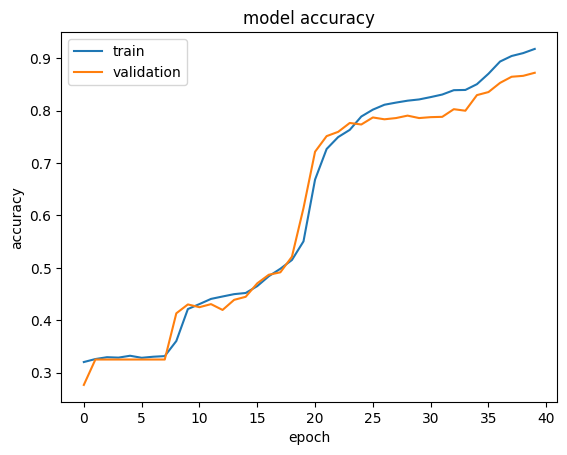

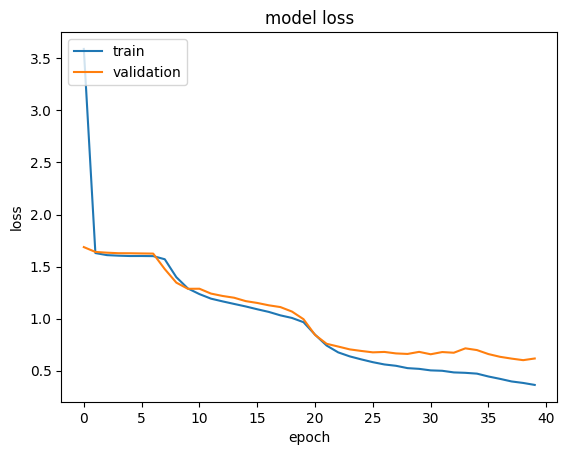

In [71]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
#Load the best weights
model.load_weights('/home/devraj4522/Desktop/ML Model/weights.h5')

In [73]:
y_pred_probabilities=model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

2023-05-21 16:40:36.174455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 16:40:36.175716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 16:40:36.176735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - 1s 6ms/step


In [74]:
#Accuracy score
print(accuracy_score(y_test,y_pred))

0.8710581639803784


In [82]:
#Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.81955   0.87061   0.84431       626
           1    0.82911   0.74432   0.78443       528
           2    0.90253   0.90658   0.90455      1338
           3    0.77409   0.73734   0.75527       316
           4    0.91851   0.93127   0.92485      1295
           5    0.75543   0.78090   0.76796       178

    accuracy                        0.87106      4281
   macro avg    0.83320   0.82850   0.83023      4281
weighted avg    0.87058   0.87106   0.87037      4281



Confusion Matrix
Axes(0.125,0.11;0.62x0.77)


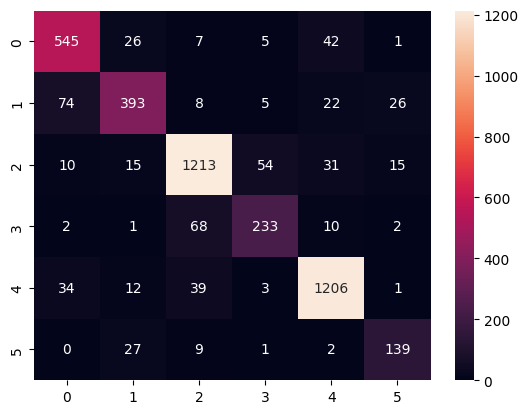

In [76]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

# Test on own

In [77]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [78]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords_list]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [79]:
predict_emotion('happy')

1/1 [==============================] - 0s 24ms/step


'happy'

In [80]:
predict_emotion('He is an arrogant and rude person')

1/1 [==============================] - 0s 53ms/step


'anger'

In [46]:
predict_emotion('The teacher is intimidating and scary')

1/1 [==============================] - 0s 27ms/step


'anger'

In [47]:
predict_emotion('love')

1/1 [==============================] - 0s 22ms/step


'anger'

In [81]:
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)